In [1]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import vedo

from histalign.backend.ccf.allen_downloads import get_structure_path
import histalign.backend.io as io
from histalign.backend.models import AlignmentParameterAggregator, VolumeSettings
from histalign.backend.registration.ReverseRegistrator import ReverseRegistrator
from histalign.backend.workspace import VolumeManager

In [2]:
vedo.settings.default_backend = "vtk"

In [3]:
results_directory = "/home/ediun/git/histalign/projects/project_310724_full/7d9af388b0"

In [4]:
# Resolution || Offset range || Total || Center ||   Dimensions
#   100um    ->  -57 to  57  =>  114  =>  57    || ( 132,  80,  114)
#    50um    -> -114 to 114  =>  228  => 114    || ( 264, 160,  228)
#    25um    -> -228 to 228  =>  570  => 228    || ( 528, 320,  456)
#    10um    -> -570 to 570  => 1425  => 570    || (1320, 800, 1140)

# ASL orientation
# X = anterior to posterior
# Y = superior to inferior
# Z = left to right

In [5]:
manager = VolumeManager()
manager.load_volume(
    "/home/ediun/.local/share/histalign/atlases/average_template_25.nrrd"
)


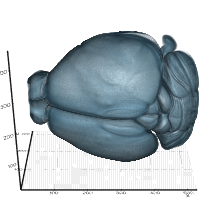

In [6]:
manager._volume

# Procedure
1. Figure out resolution
2. Create numpy array with correct dimensions
3. Load image
4. Mask off region of interest
5. Insert masked image at right offset in numpy array
6. Repeat from 3 until all images processed
7. Convert numpy array to vedo volume
8. Visualise?

## Figure out resolution

In [7]:
project_file = str(Path(results_directory).parent / "project.json")

with open(project_file) as handle:
    project_resolution = json.load(handle)["atlas_resolution"]

## Create numpy array with correct dimensions

In [8]:
dimensions_map = {
    100: (132, 80, 114),
    50: (264, 160, 228),
    25: (528, 320, 456),
    10: (1320, 800, 1140),
}

dimensions = dimensions_map[project_resolution]

volume_array = np.zeros(dimensions)

## Load image + mask off + insert

In [9]:
def get_parameters(alignment_path: str) -> AlignmentParameterAggregator:
    with open(alignment_path) as handle:
        return AlignmentParameterAggregator(**json.load(handle))


def mask_off(
    image_array: np.ndarray,
    structure_name: str,
    parameters: AlignmentParameterAggregator,
) -> np.ndarray:
    mask_volume = VolumeManager()
    mask_volume.load_volume(get_structure_path(structure_name, parameters.resolution))

    volume_settings = VolumeSettings()
    volume_settings.offset = parameters.offset

    mask_slice = mask_volume.slice_volume(volume_settings)

    reverse_registrator = ReverseRegistrator(True, True)
    registered_image_array = reverse_registrator.get_forwarded_image(
        parameters, image_array
    )

    return np.where(mask_slice > 0, registered_image_array, 0)


def insert_into_array(
    minor_array: np.ndarray,
    master_array: np.ndarray,
    parameters: AlignmentParameterAggregator,
) -> np.ndarray:
    def convert_offset_to_index(offset: int, resolution: int) -> int:
        anti_offset_map = {100: 57, 50: 114, 25: 228, 10: 270}
        return offset + anti_offset_map[resolution]

    index = convert_offset_to_index(parameters.offset, parameters.resolution)
    master_array[..., index] = minor_array
    return master_array


def process_alignment(
    alignment_path: str,
    structure_name: str,
    master_array: np.ndarray,
    neun: bool = True,
) -> np.ndarray:
    print("Getting parameters")
    parameters = get_parameters(str(alignment_path))
    print("Getting raw image")
    if neun:
        raw_image = io.load_image(
            parameters.histology_file_path, normalise_dtype=np.uint8
        )
    else:
        path = parameters.histology_file_path.replace("channel1", "channel2").replace(
            "470_New 1", "700_New 2"
        )
        raw_image = io.load_image(path, normalise_dtype=np.uint8)
    print("Getting masked image")
    masked_image = mask_off(raw_image, structure_name, parameters).T

    return insert_into_array(masked_image, master_array, parameters)

In [10]:
alignment_paths = []
for path in Path(results_directory).iterdir():
    if path.is_dir() or path.stem == "metadata" or path.suffix != ".json":
        continue

    alignment_paths.append(path)

In [11]:
neun = False
volume_array_path = (
    f"notebooks/resources/volume_array_{'neun' if neun else 'mecp2'}.npy"
)

if os.path.exists(volume_array_path):
    volume_array = np.load(volume_array_path)
else:
    i = 0
    for alignment_path in alignment_paths:
        i += 1
        print(f"Processing {i}")

        volume_array = process_alignment(
            alignment_path, "Isocortex", volume_array, neun
        )

    # Ensuring we have only unique offsets
    j = 0
    for k in range(volume_array.shape[-1]):
        if volume_array[..., k].max() > 0:
            j += 1

    assert i == j, "Some offsets were the same, previous slices were overwritten"

    np.save(volume_array_path, volume_array)

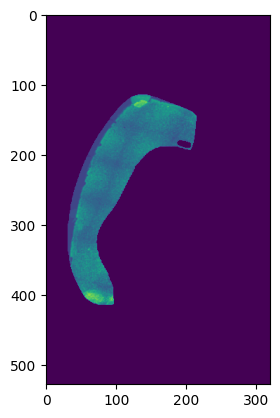

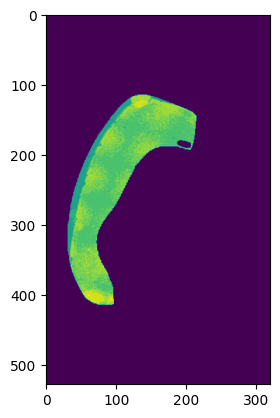

In [12]:
index = 104
plt.imshow(volume_array[..., index])
plt.show()
plt.imshow(
    np.digitize(volume_array, np.geomspace(1, 2**8 - 1, 25, dtype=int))[..., index]
)
plt.show()

In [17]:
# vedo_ready_array = np.digitize(volume_array, np.geomspace(1, 2 ** 8 - 1, 25)).astype(np.uint8)
vedo_ready_array = volume_array

# Normalise
vedo_ready_array = io.normalise_array(vedo_ready_array, np.uint8)


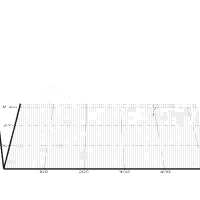

In [20]:
volume = vedo.Volume(vedo_ready_array)

# Crop since only working with a single hemisphere for now
volume.crop(top=0.5)


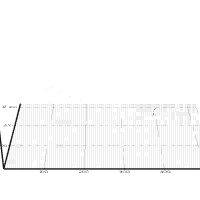

In [21]:
volume.smooth_gaussian(sigma=(0.01,) * 3)

In [22]:
lego = volume.clone().legosurface(vmin=1, vmax=255)
lego.show()

In [23]:
volume.show()

In [16]:
isocortex_volume = VolumeManager()
isocortex_volume.load_volume(get_structure_path("Isocortex", 25))
isocortex_volume._volume.crop(bottom=0.5)

isocortex_volume._volume.tonumpy()[:] = isocortex_volume._volume.tonumpy() * (2**8 - 1)
isocortex_volume._volume.modified()

total_volume = volume.append(isocortex_volume._volume, axis="z")

In [17]:
total_lego = total_volume.legosurface(vmin=100)

In [18]:
total_lego.show()

In [38]:
total_volume.show()